In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]


2024-08-20 13:45:41.448733: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-20 13:45:41.492757: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

In [3]:
esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

In [4]:
num_metasturctures_list = [5, 10, 20]

contact_threshold = 250
esc_contact_maps = esc_maps_interp < 250
cnc_contact_maps = cnc_maps_interp < 250

def count_stack_contacts(contact_maps):
    num_contacts_15 = np.sum(contact_maps[15, 15:42])
    num_contacts_42 = np.sum(contact_maps[15:42, 42])
    return num_contacts_15 + num_contacts_42

esc_stack_count = [count_stack_contacts(x) for x in esc_contact_maps]
cnc_stack_count = [count_stack_contacts(x) for x in cnc_contact_maps]

distance_maps_list = []
for num_metastructures in num_metasturctures_list:
    bins = np.linspace(0, 51, num_metastructures+1)
    labels = np.arange(len(bins) - 1)
    print(labels)

    esc_stack_bins = pd.cut(esc_stack_count, bins, labels=labels)
    cnc_stack_bins = pd.cut(cnc_stack_count, bins, labels=labels)

    # Combine data from esc and cnc that are assigned to the same bin
    all_stack_bins = np.concatenate((esc_stack_bins, cnc_stack_bins))
    all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)

    distance_maps_bins = []
    for i in range(len(labels)):
        distance_maps_bins.append(np.median(all_maps_interp[all_stack_bins == i], 0))
    distance_maps_list.append(distance_maps_bins)

[0 1 2 3 4]
[0 1 2 3 4 5 6 7 8 9]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


In [5]:
[len(x) for x in distance_maps_list]

[5, 10, 20]

In [6]:
def load_weights(directory, num_metastructures):
    log_weights = []
    lp = []
    files = sorted(os.listdir(directory))[-4:]
    print(files)
    
    log_weights_d = []
    for file in files:
        log_weights_chain = []
        lp_chain = []
        with open('%s/%s'%(directory, file), newline='') as csvfile:
            reader = csv.DictReader(filter(lambda row: row[0]!='#', csvfile), )
            for row in reader:
                log_weights_row = [float(row["log_weights.%d"%i]) for i in range(1,num_metastructures+1)]
                lp_chain.append(float(row["lp__"]))
                log_weights_chain.append(log_weights_row)
        log_weights = np.array(log_weights_chain)
        lp_chain = np.array(lp_chain)
        log_weights_d.append(log_weights)
        lp.append(lp_chain)
    log_weights_d = np.array(log_weights_d)
    return log_weights_d 

In [7]:
common_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/MCMC_results/20240815_WeightMCMC_stack_contact_diff'


In [8]:
esc_log_weights_dict = {}
cnc_log_weights_dict = {}
for x in num_metasturctures_list:
    print(x)
    stan_directory_esc = os.path.join(common_dir, '{}_metastructures/ESC/stan_output'.format(x))
    stan_directory_cnc = os.path.join(common_dir, '{}_metastructures/CNC/stan_output'.format(x))
    esc_log_weights_dict[x] = load_weights(stan_directory_esc, x)
    cnc_log_weights_dict[x] = load_weights(stan_directory_cnc, x)

5
['20240715_WeightOptimization-20240816160044_1.csv', '20240715_WeightOptimization-20240816160044_2.csv', '20240715_WeightOptimization-20240816160044_3.csv', '20240715_WeightOptimization-20240816160044_4.csv']
['20240715_WeightOptimization-20240816160059_1.csv', '20240715_WeightOptimization-20240816160059_2.csv', '20240715_WeightOptimization-20240816160059_3.csv', '20240715_WeightOptimization-20240816160059_4.csv']
10
['20240715_WeightOptimization-20240816160120_1.csv', '20240715_WeightOptimization-20240816160120_2.csv', '20240715_WeightOptimization-20240816160120_3.csv', '20240715_WeightOptimization-20240816160120_4.csv']
['20240715_WeightOptimization-20240816160143_1.csv', '20240715_WeightOptimization-20240816160143_2.csv', '20240715_WeightOptimization-20240816160143_3.csv', '20240715_WeightOptimization-20240816160143_4.csv']
20
['20240715_WeightOptimization-20240816160205_1.csv', '20240715_WeightOptimization-20240816160205_2.csv', '20240715_WeightOptimization-20240816160205_3.csv',

In [9]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240816'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

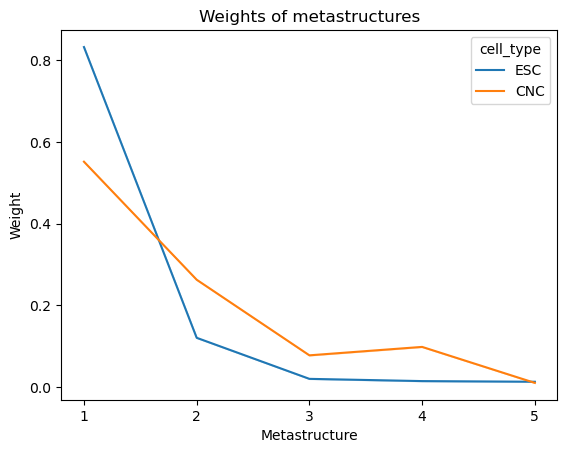

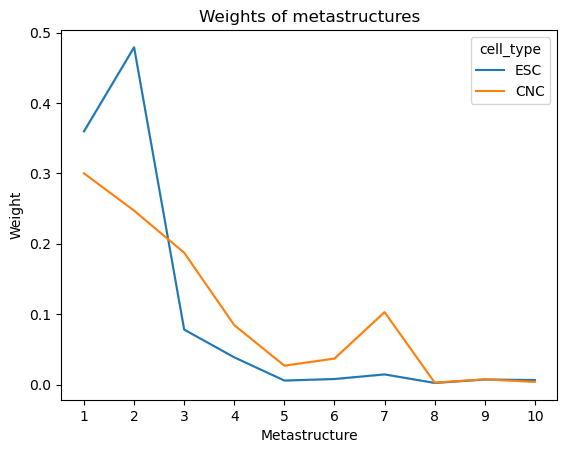

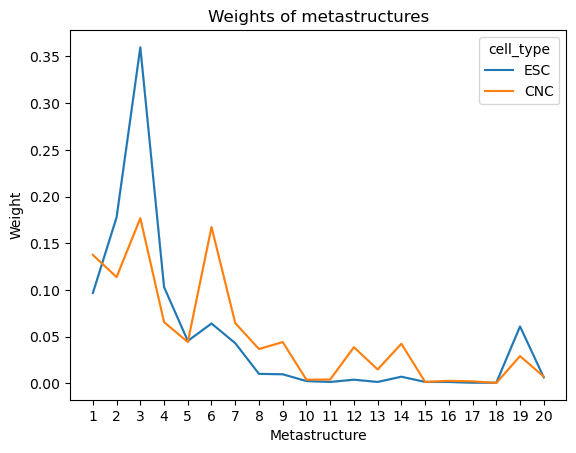

In [10]:
for x in num_metasturctures_list:
    # Add these log weights to the dataframe
    # Reshape the log weights - 10 columns 
    esc_log_weights = esc_log_weights_dict[x].reshape(-1, x)

    # Then add each column to the dataframe with distinct labels
    # values are in the same column, label is in another column
    esc_weight_df = pd.DataFrame()
    esc_weight_df['log_weight'] = np.exp(esc_log_weights.reshape(-1, x).flatten())
    esc_weight_df['label'] = np.tile(np.arange(x), esc_log_weights.reshape(-1, x).shape[0])
    esc_weight_df['cell_type'] = 'ESC'

    # Do the same for CNC
    cnc_log_weights = cnc_log_weights_dict[x].reshape(-1, x)
    cnc_weight_df = pd.DataFrame()
    cnc_weight_df['log_weight'] = np.exp(cnc_log_weights.reshape(-1, x).flatten())
    cnc_weight_df['label'] = np.tile(np.arange(x), cnc_log_weights.reshape(-1, x).shape[0])
    cnc_weight_df['cell_type'] = 'CNC'
    
    all_weight_df = pd.concat([esc_weight_df, cnc_weight_df])
    
    # Plot the log weights on a line plot with error bar using seaborn
    sns.lineplot(data=all_weight_df, x='label', y='log_weight', hue='cell_type', errorbar='ci')
    plt.title('Weights of metastructures')
    plt.xlabel('Metastructure')
    plt.ylabel('Weight')
    plt.xticks(np.arange(x), np.arange(x)+1)
    plt.savefig(save_dir + '/metastructure_weights.png', dpi=300, bbox_inches='tight')
    plt.show()



In [12]:
num_metasturctures_list

[5, 10, 20]

In [18]:
x = num_metasturctures_list[-1]
esc_log_weights = np.mean(esc_log_weights_dict[x].reshape(-1, x), 0)
esc_weights = np.exp(esc_log_weights)

cnc_log_weights = np.mean(cnc_log_weights_dict[x].reshape(-1, x), 0)
cnc_weights = np.exp(cnc_log_weights)

ratio_list = np.log(cnc_weights/esc_weights)


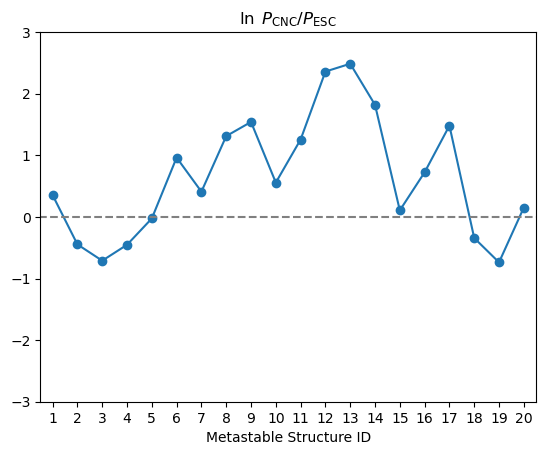

In [30]:
plt.plot(ratio_list, 'o-')
plt.ylim([-3, 3])
plt.xlim(-0.5, 19.5)
plt.title(r'$\ln \; P_\mathrm{CNC}/P_\mathrm{ESC}$')
plt.hlines(0, -1, 20, 'gray', 'dashed')
plt.xticks(np.arange(20), np.arange(20)+1)
plt.xlabel('Metastable Structure ID')
plt.savefig(save_dir + '/stack_prob_ratio.png', dpi=300, bbox_inches='tight')

In [17]:
esc_log_weights.shape

(20,)

In [11]:
num_metasturctures_list[-1]

20

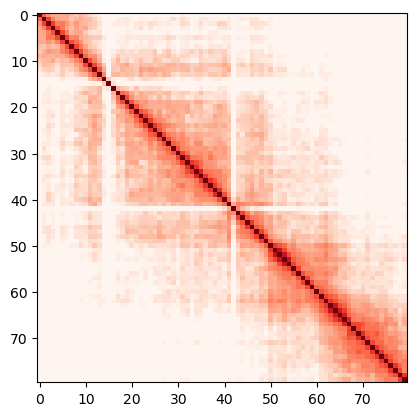

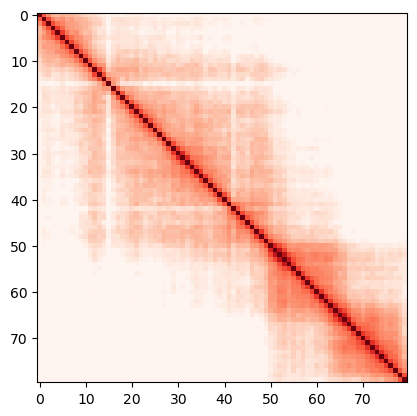

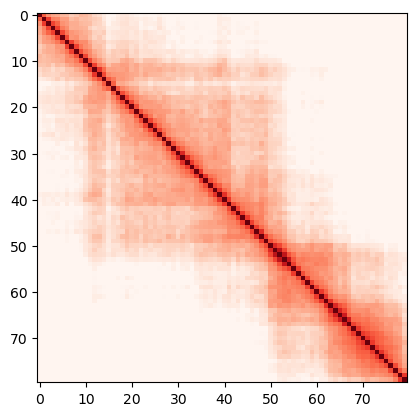

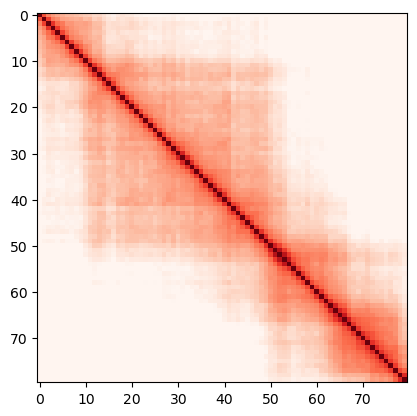

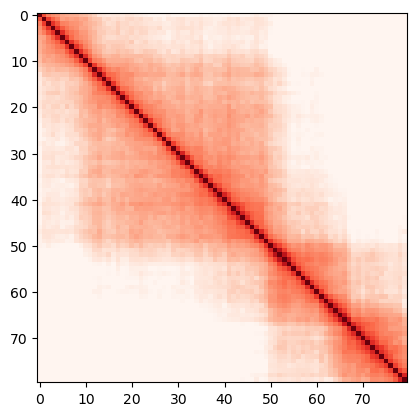

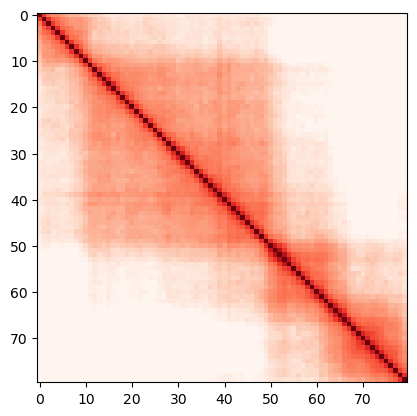

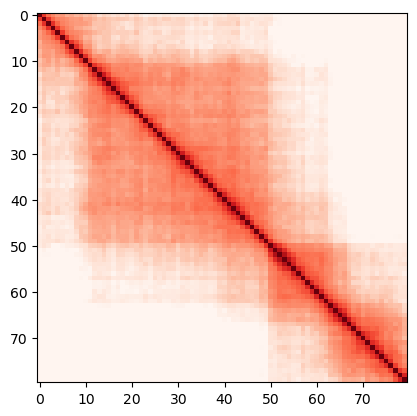

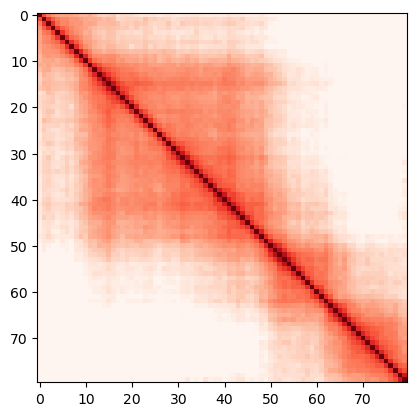

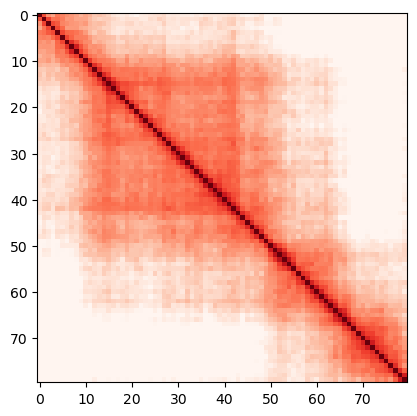

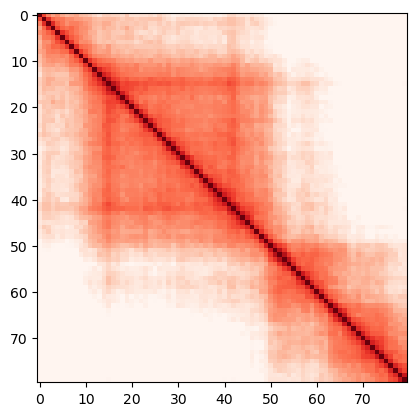

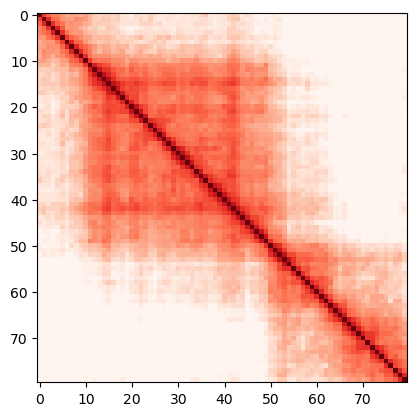

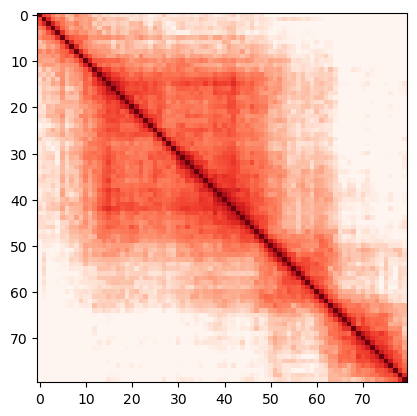

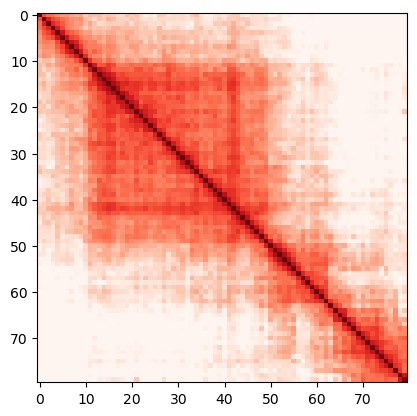

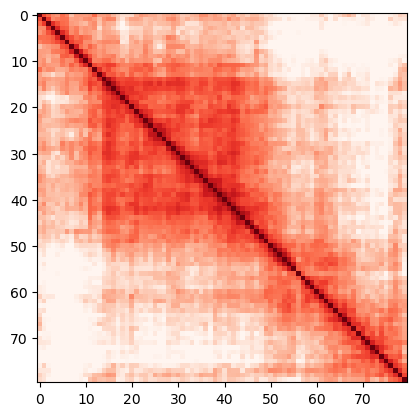

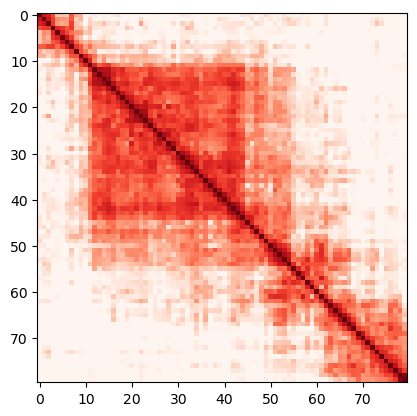

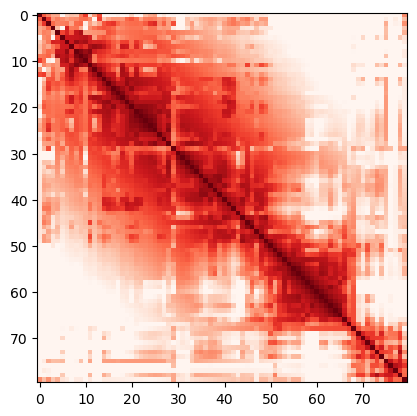

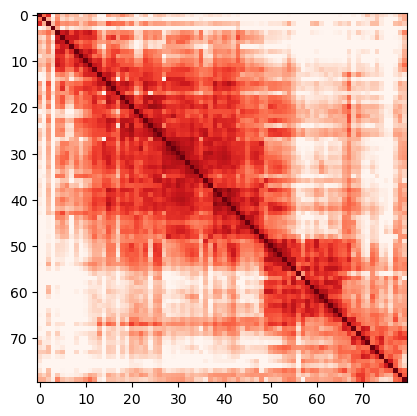

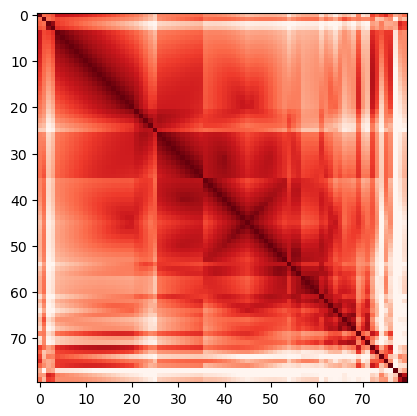

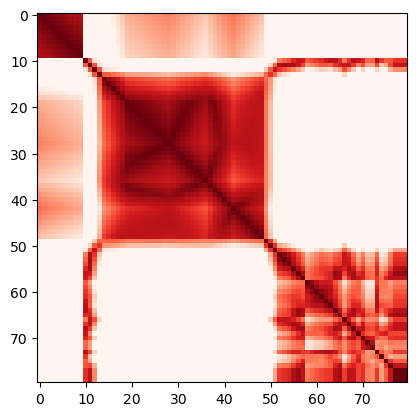

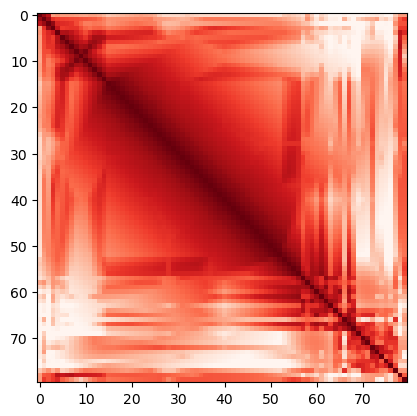

In [16]:
for x in range(num_metasturctures_list[-1]):
    plt.imshow(distance_maps_list[-1][x].reshape(80, 80),
               cmap='Reds_r', vmin=0, vmax=600)
    plt.savefig(save_dir + '/median_distance_map_bin_{}.png'.format(x), dpi=300, bbox_inches='tight')
    plt.show()

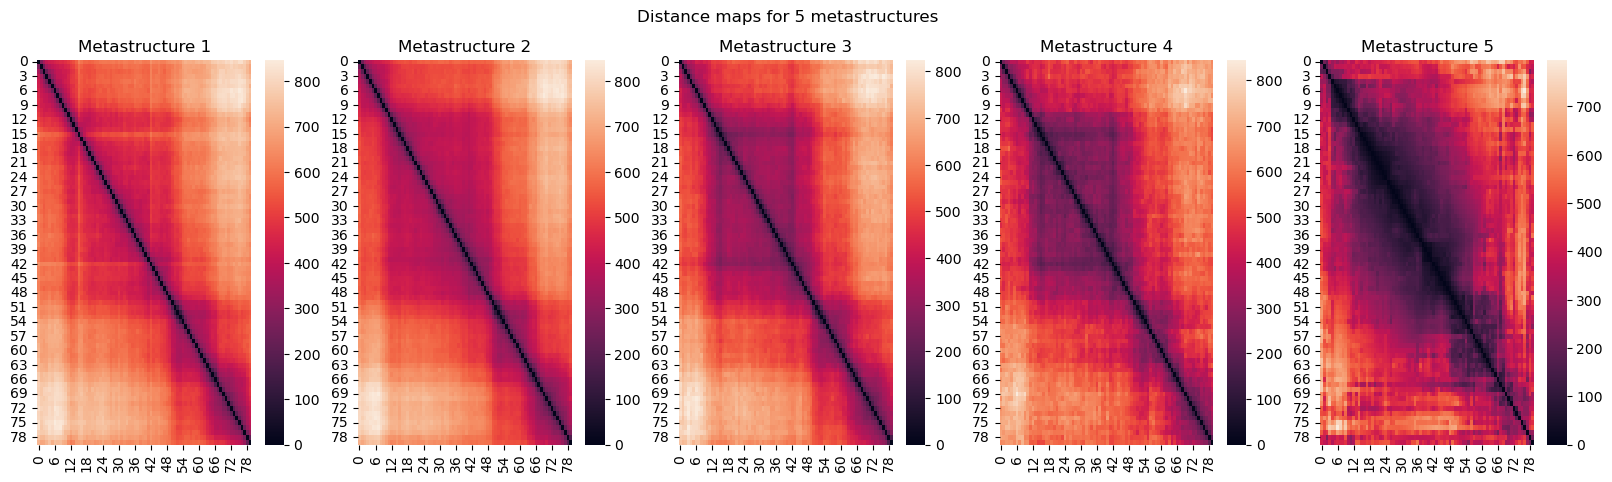

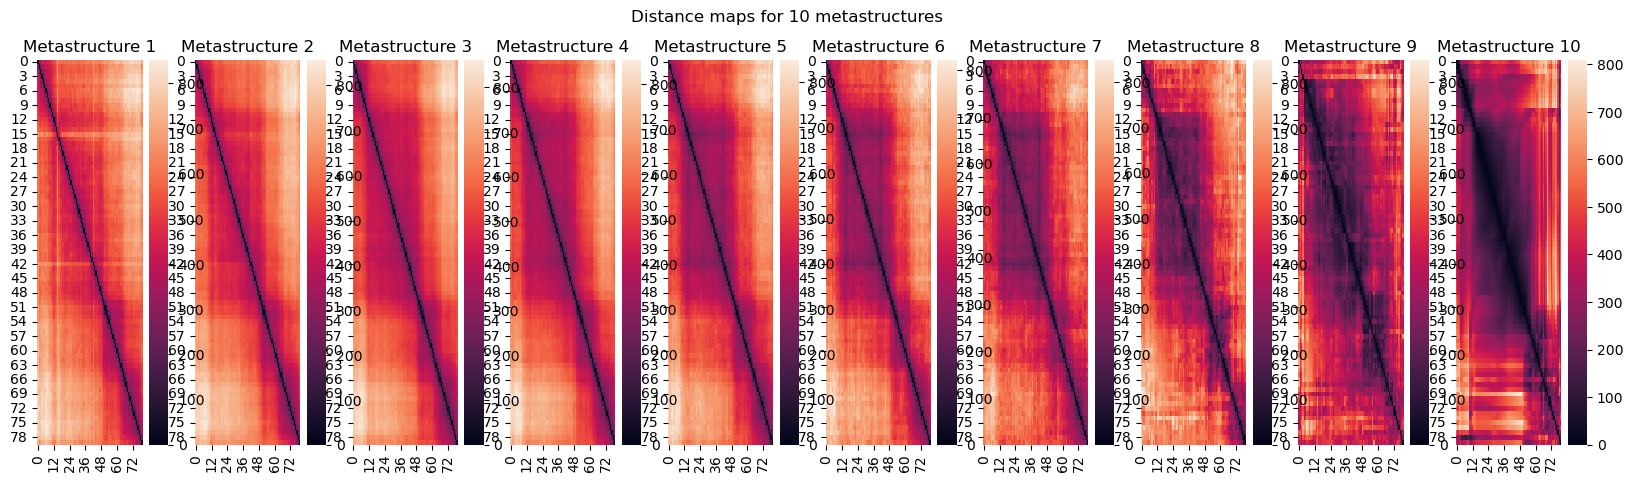

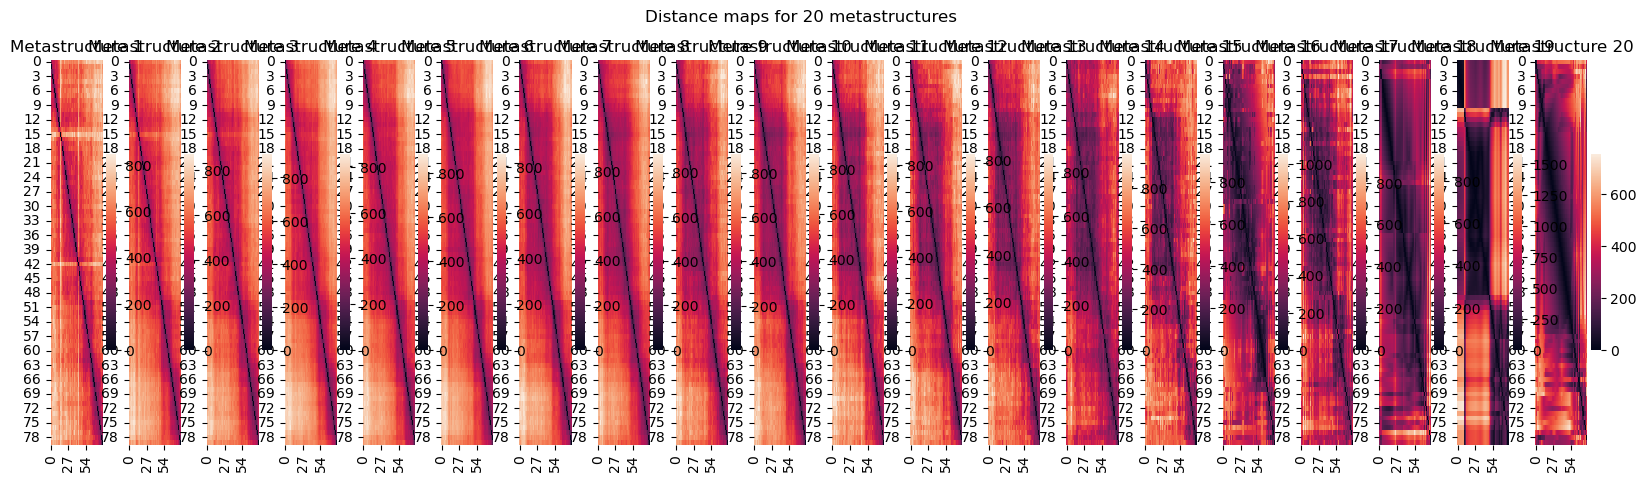

In [37]:
# Plot the distance maps in the same row for each metastructure
for x in num_metasturctures_list:
    fig, axs = plt.subplots(1, x, figsize=(20, 5))
    for i in range(x):
        sns.heatmap(distance_maps_list[num_metasturctures_list.index(x)][i].reshape(80, 80), ax=axs[i])
        axs[i].set_title('Metastructure %d'%(i+1))
    plt.suptitle('Distance maps for %d metastructures'%x)
    plt.savefig(save_dir + '/distance_maps_%d_metastructures.png'%x, dpi=300, bbox_inches='tight')
    plt.show()